In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Initial Investigation

In [51]:
print(f"Shape: {train.shape}")
print(f"Columns: {train.columns}")
print(f"dtypes: {train.dtypes}")

Shape: (7905, 20)
Columns: Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')
dtypes: id                 int64
N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object


# Recoding and Missing Values

Drugs, Ascites, Hepatomegaly, Spiders, Cholesterol, and every continuous variable after Albumin have missing values.

## Find cols with missing values: Discrete Variables

In [52]:
# Convert dichotomous categorical to dummies
discrete_vars = train.select_dtypes('object').columns

for column in discrete_vars:
    print(train.loc[:, column].value_counts())

Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64
Sex
F    7336
M     569
Name: count, dtype: int64
Ascites
N    7525
Y     380
Name: count, dtype: int64
Hepatomegaly
Y    4042
N    3863
Name: count, dtype: int64
Spiders
N    5966
Y    1939
Name: count, dtype: int64
Edema
N    7161
S     399
Y     345
Name: count, dtype: int64
Status
C     4965
D     2665
CL     275
Name: count, dtype: int64


## Find cols with missing values: Continuous Variables

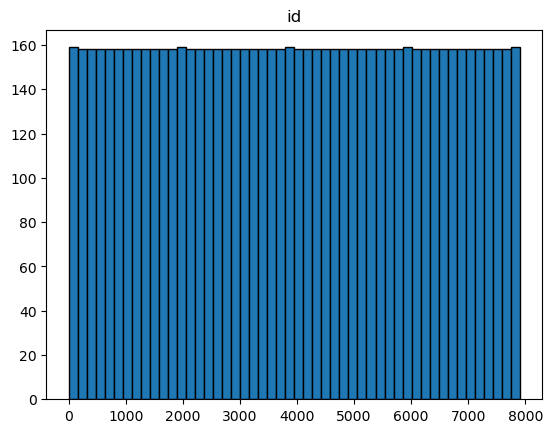

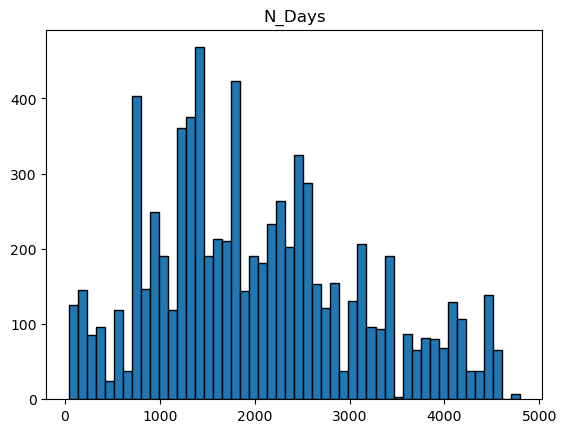

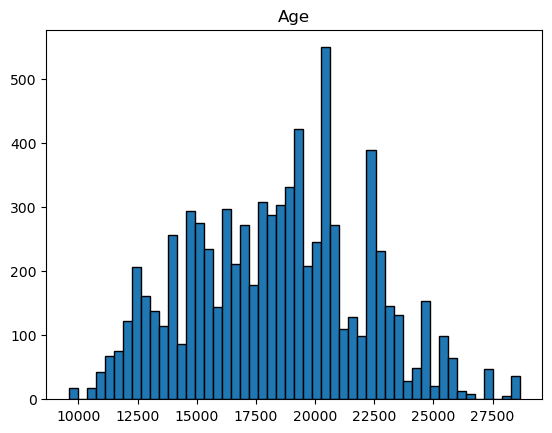

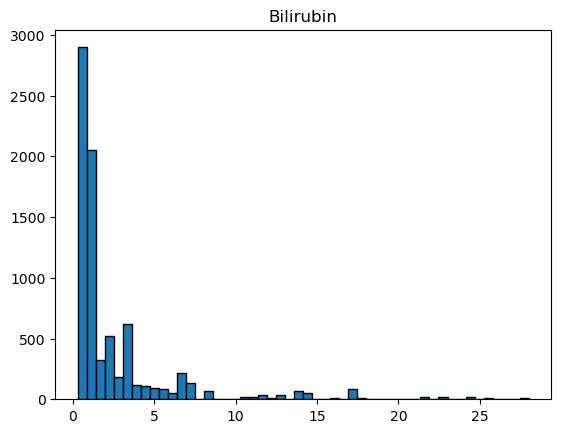

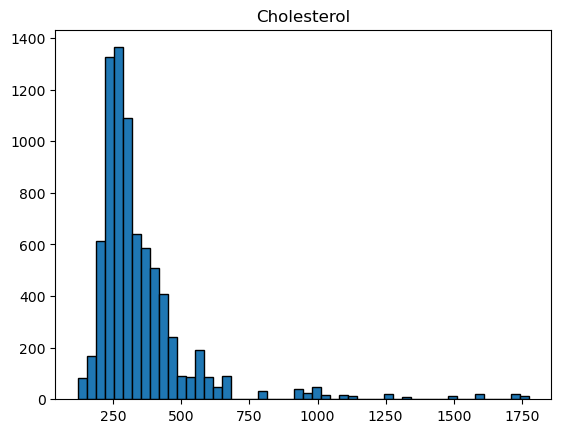

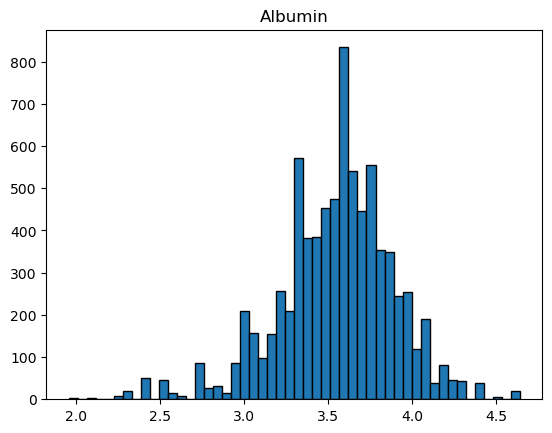

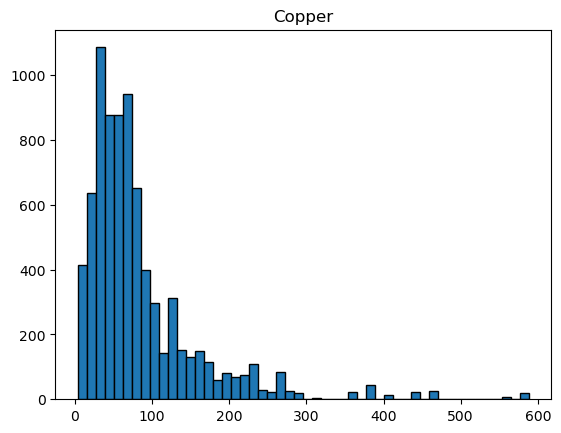

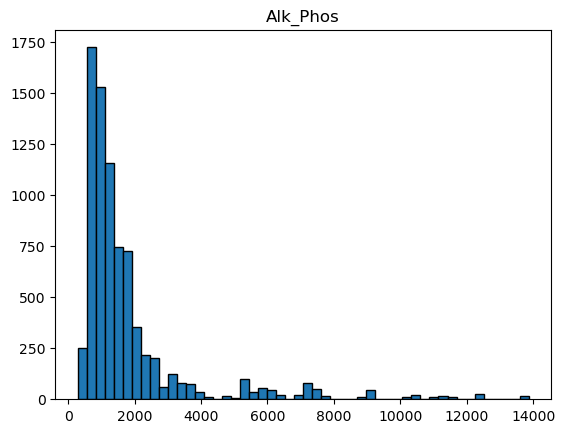

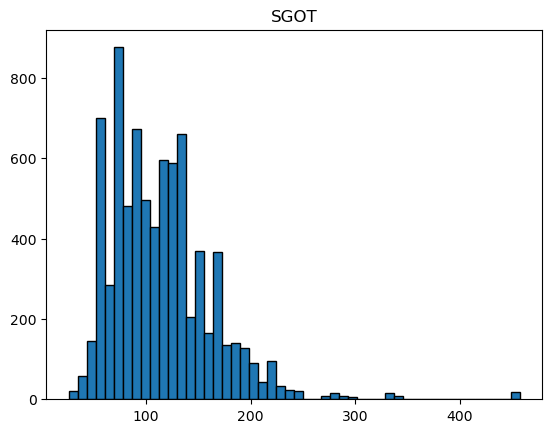

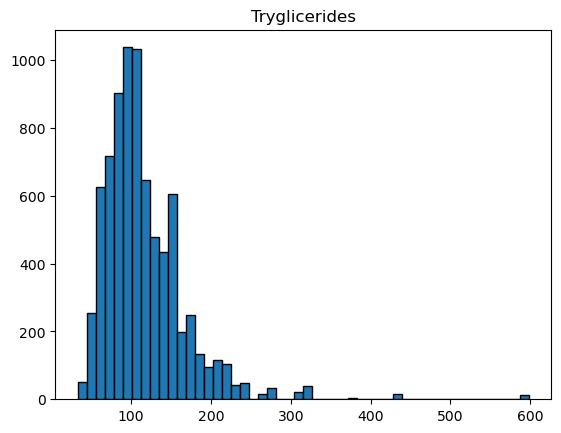

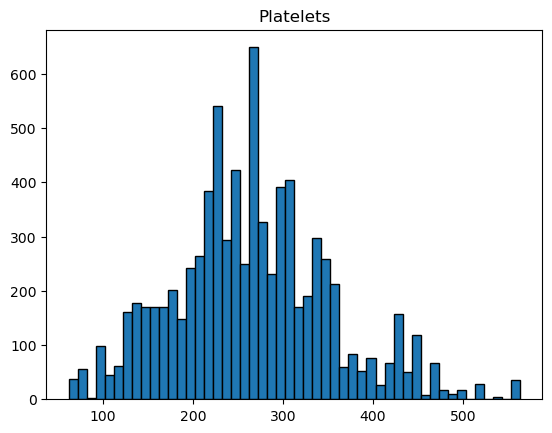

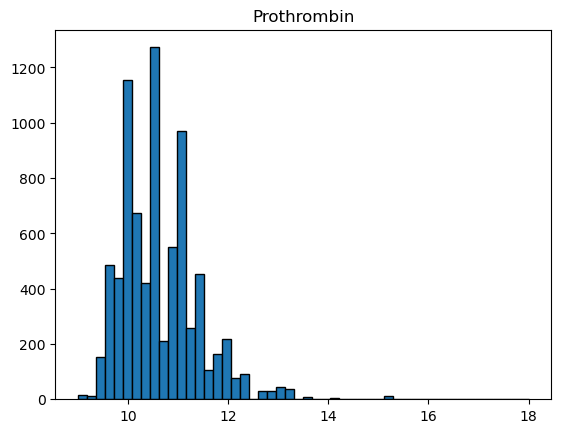

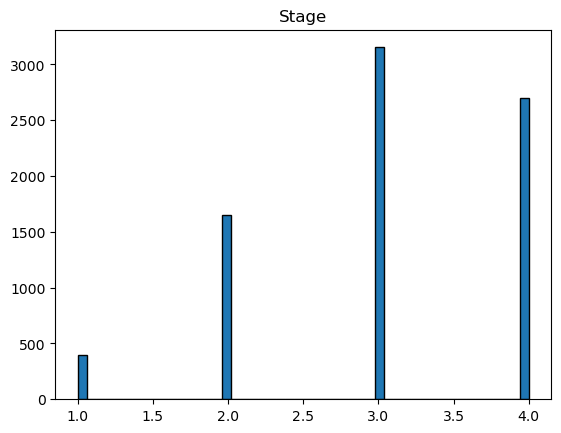

In [53]:
continuous_vars = train.select_dtypes(['float64', 'int64']).columns

for column in continuous_vars:
    plt.hist(train[column], bins=50, edgecolor='black')  # Adjust the number of bins as needed
    plt.title(f'{column}')
    plt.show()

Some variables are on different scales, and their ranges and distributions vary a lot.

## Check for NaN in continuous

In [54]:
train[continuous_vars].isnull().sum()

id               0
N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

If there are missings, they aren't encoded as NaN.

There are very few features, and it is likely that they're all important to the analysis, so there is much feature engineering to do.